# Multi-level Models in Keras Playground

Linear Mixed effects models, also known as hiearchical linear models, also known as multi-level models, are powerful linear ensemble modeling tools that can do both regression and classification tasks for many structured data sets. This notebook describes what a multi-level model is, and how to implement a model using the neural network library keras. Model outputs are compared to multi-level models available in the statsmodels package.

A comparison among:  
[StatsModels](https://github.com/statsmodels/statsmodels)  
[Keras](https://github.com/fchollet/keras) with Tensorflow backend

For brevity, this tutorial will ignore cross-validation and hold out data as tools for model assessment.

## A very brief introduction to multi-level models

Multi-level models account for different levels within a data set. Levels are groupings of data that apply across several observations. For example, a classic data set (simulated below), is the math achievement versus SES status for students who attend catholic schools versus public schools. The first level is the student's SES, whereas the second level is their attended school. Multi-level models can account for fixed effects (i.e., the variance does not change within groups), and random effects (i.e., the variance is distributed across groups). Multi-level models are linear models. In the case of the catholic school data set the equation that predicts student math achievement is:

This equation is wrong lol

$$ math\_achievement = \alpha_{01} + \beta_{01} * SES + \beta_{02} * catholic\_school $$

Takes the general form of:

$$ Y_{ij} = \beta_{0j} + \beta_{1j}X+{ij} + r_{ij} $$
$$ \beta_{0j} = \gamma_{00} + \gamma_{01}W_j + u_{0j} $$
$$ \beta_{1j} = \gamma_{10} + \gamma_{11}W_j + u_{1j} $$

And the more specific form:

$$ Y_{math achievement, i} = \beta{0,school} + \beta_{1,school}X_{i, SES} + \beta_{2,school}X_{i,school} + r_{i,j} $$
$$ \beta_{0, school} = \gamma_{00} + \gamma_{01}W_{school} + u_{0, school} $$
$$ \beta_{1, school} = \gamma_{00} + \gamma_{11}W_{school} + u_{0, school} $$ 

Where

| variable                               | description                                                                                      |
|----------------------------------------|--------------------------------------------------------------------------------------------------|
| $i=1,2,3...$                           | the student indicator, i.e., the student ID.                                                     |
| $j=catholic,public$                    | the school group indicator                                                                       |
| $\beta_{0, school}$,$\beta_{1,school}$ | level-1 coefficients. in this case the SES status and the categorical school belonging variable. |
| $\gamma_{00}...\gamma{11}$             | level-2 coefficients. Also known as fixed effects.                                               |
| $X_{ij}$                               | Level-1 variable. SES, etc.                                                                      |
| $W_{ij}$                               | Level-2 predictor. school belonging, etc.                                                        |
| $r_{ij}$                               | Level-1 random effect.                                                                           |
| $u_{0,j},u_{1,j}...$                   | Level-2 random effects.                                                                          |

These equations in summation for different intercepts and coefficients for models depending on whether a student attended a catholic school or public school.



In [1]:
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

%load_ext watermark

`watermark` prints the versions of libraries, pythons, and computer hardware in case this matters for your use of this notebook. It notes that `keras` is not installed. This is because `keras` comes with a `tensorflow` installation and thus does not need to be installed again.

In [2]:
%watermark -v -m -p numpy,pandas,statsmodels,tensorflow,keras,matplotlib

CPython 3.6.9
IPython 7.8.0

numpy 1.16.4
pandas 0.25.1
statsmodels 0.10.1
tensorflow 1.12.0
keras not installed
matplotlib 3.1.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 20
interpreter: 64bit


# Prepare data and quick visualization

For the first comparison, we use the california housing data set and create a categorical variable called `popGroup` to represent whether a region is 'high' or 'low' in population. `sklearn` has many built in data sets that include data descriptions. The california housing data set has no strong correlations between data points and makes for a good first attempt at modeling data.

In [3]:
from sklearn.datasets import fetch_california_housing as get_data
data = get_data()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
# popGroup is high=1; low=0
df['popGroup'] = df.Population.apply(lambda x: 1 if x >= 1000 else 0).astype('category')
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,popGroup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,0


In [4]:
print(data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

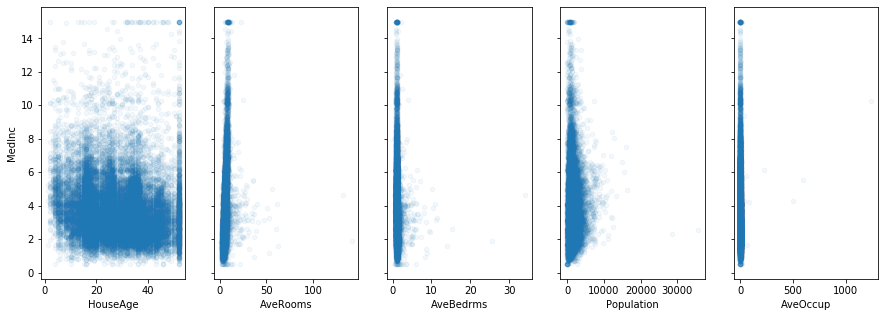

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

for n, c in enumerate(df.columns[1:6]):
    df.plot.scatter(ax=ax[n], x=c, y='MedInc', alpha=0.05)

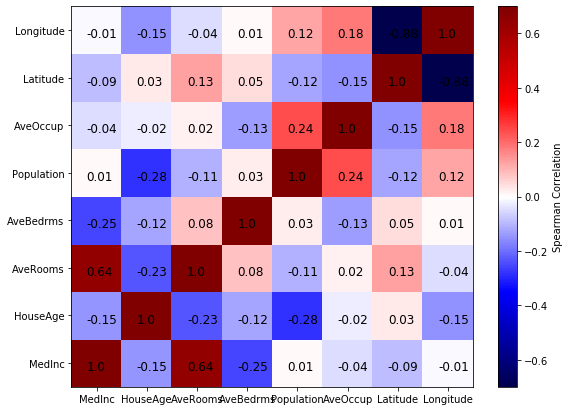

In [6]:
fig, ax = plt.subplots(figsize=(9, 7))
z = df.corr('spearman')
cbar = ax.pcolormesh(z, cmap='seismic', vmin=-0.7, vmax=0.7)
fig.colorbar(cbar, label='Spearman Correlation')
ax.set_xticks(np.arange(0, 8, 1)+0.5)
ax.set_yticks(np.arange(0, 8, 1)+0.5)
ax.set_xticklabels(z.columns)
ax.set_yticklabels(z.index)
for n,mc in enumerate(z.values):
    for i,m in enumerate(mc):
        ax.text(n+0.3, i+0.35, str(round(m,2)), color='black', fontsize=12)

# Using StatsModels to perform a linear mixed model of reaction time
`statsmodels` can use `R`-like formulas to define fixed effects equations. However it uses the groups argument instead of the `|` within the equation to declare random effects. It is common practice to have a variable that has random effects also have fixed effects. This is because [random effects without fixed effects implies that the variable has no average effect.](https://stats.stackexchange.com/questions/173159/can-a-variable-be-both-random-and-fixed-effect-at-the-same-time-in-a-mixed-effec)

In [7]:
# https://www.statsmodels.org/stable/mixed_linear.html
formula = "MedInc ~ AveRooms + AveBedrms + AveRooms*AveBedrms + C(popGroup)"
md  = smf.mixedlm(formula, df, groups=df['popGroup'])
mdf = md.fit()
print(mdf.summary())

fe_params = pd.DataFrame(mdf.fe_params,columns=['LMM'])
random_effects = pd.DataFrame(mdf.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})
random_effects


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   MedInc     
No. Observations:   20640     Method:               REML       
No. Groups:         2         Scale:                1.7469     
Min. group size:    8143      Likelihood:           -35062.0037
Max. group size:    12497     Converged:            Yes        
Mean group size:    10320.0                                    
---------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept           3.689    1.322    2.790 0.005  1.097  6.281
C(popGroup)[T.1]    0.024    1.869    0.013 0.990 -3.640  3.687
AveRooms            1.031    0.007  145.815 0.000  1.017  1.045
AveBedrms          -4.966    0.044 -112.068 0.000 -5.053 -4.879
AveRooms:AveBedrms  0.002    0.000    5.451 0.000  0.001  0.003
Group Var           1.747                            

/home/john/anaconda3/envs/research/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/john/anaconda3/envs/research/lib/python3.6/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


,Group
0,1.889395e-10
1,1.510772e-09


In this case it seems like these groups are not so important (high or low population). However the other features in the model seem to be able to explain at least half the variance in the median incomes of home owners in southern california.

R2 score: 0.5161050839597088


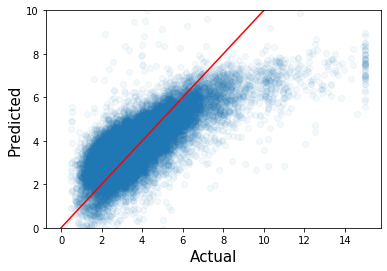

In [8]:
ypred = mdf.predict(df)

fig, ax = plt.subplots()
ax.scatter(df['MedInc'], ypred, alpha=0.05)
ax.set_ylim(0, 10)
ax.set_ylabel('Predicted', fontsize=15)
ax.set_xlabel('Actual', fontsize=15)
ax.plot([0, 10], [0, 10], color='red')
print('R2 score:', r2_score(df['MedInc'], ypred))

# creating a design matrix from a statsmodels formula

`statsmodels` can accept `pandas` dataframes directly as input with the defined groups. `keras` can not. Thus we need to create a [design matrix](https://en.wikipedia.org/wiki/Design_matrix) directly for training the `keras` model.

In [9]:
Y, X = dmatrices(formula, data=df, return_type='matrix')
Terms = X.design_info.column_names
_, Z = dmatrices('MedInc ~ -1+popGroup', data=df, return_type='matrix')
X = np.asarray(X) # fixed effect
Z = np.asarray(Z) # mixed effect
Y = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)

# Using Keras

`keras` is a library that allows the construction of neural networks. Neural networks at the most basic level are linear combinations of variables, that is linear models. They can include a lot more sophistication but at their core, they are no different than any other model that is based on linear combinations of variables. Thus, `keras` provides a modular and verbose way to construct multi-level models.



In [10]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
K.clear_session()
nb_epoch = 250

fixedpred = np.argmax(X,axis=1)
randmpred = np.argmax(Z,axis=1)

Xinput      = Input(batch_shape=(None, nfixed[1]-1))
fixed_keras = Dense(1, input_dim=nfixed[1]-1, name = 'fixedEffect')(Xinput)

Zinput     = Input(batch_shape=(None, nrandm[1]))
randm_keras = Dense(1, input_dim=nrandm[1], use_bias=None, name = 'randomEffect')(Zinput)

merged = keras.layers.add([fixed_keras, randm_keras])

model = Model([Xinput, Zinput], merged)

model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
model.fit([X[:,1:], Z], Y.flatten(), 
          epochs=nb_epoch, 
          batch_size=100, 
          verbose=1,
          shuffle=True,
          )

Ypredict = model.predict([X[:,1:], Z])

betakeras = np.hstack((model.get_weights()[1], model.get_weights()[0].flatten()))
bkeras    = model.get_weights()[2].flatten()

Epoch 1/250
20640/20640 [==============================] - 1s 62us/step - loss: 769.2214
Epoch 2/250
20640/20640 [==============================] - 1s 26us/step - loss: 682.8291
Epoch 3/250
20640/20640 [==============================] - 1s 26us/step - loss: 620.8162
Epoch 4/250
20640/20640 [==============================] - 1s 26us/step - loss: 552.5054
Epoch 5/250
20640/20640 [==============================] - 1s 26us/step - loss: 495.9585
Epoch 6/250
20640/20640 [==============================] - 1s 26us/step - loss: 443.9011
Epoch 7/250
20640/20640 [==============================] - 1s 26us/step - loss: 394.7998
Epoch 8/250
20640/20640 [==============================] - 1s 26us/step - loss: 351.0910
Epoch 9/250
20640/20640 [==============================] - 1s 26us/step - loss: 307.8472
Epoch 10/250
20640/20640 [==============================] - 1s 26us/step - loss: 271.1613
Epoch 11/250
20640/20640 [==============================] - 1s 26us/step - loss: 238.6640
Epoch 12/250
20640/

In [ ]:
fe_params['Keras'] = pd.Series(betakeras, index=fe_params.index)
random_effects['Keras'] = pd.Series(bkeras, index=random_effects.index)
fe_params

In [ ]:
fig, ax = plt.subplots(figsize=(5, 10))

yticks = np.arange(fe_params.shape[0])
ax.plot(fe_params, yticks)
ax.set_yticks(yticks)
ax.set_yticklabels(labels=fe_params.index, rotation=0)

ax.legend(['LMM', 'Keras'], fontsize=15)
ax.set_xlabel('Coefficient value', fontsize=15)

In [ ]:
random_effects

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

random_effects.reset_index().plot(ax=ax)
# ax.set_xticks(np.arange(0, 20, 1))
ax.set_title('random effects', fontsize=15)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(ypred, Ypredict, alpha=0.5, label='model comparison')
ax.plot([-100, 100], [-100, 100], label='perfect match', color='red')
ax.set_ylabel('Keras', fontsize=15)
ax.set_xlabel('statsmodels', fontsize=15)
ax.set_ylim(-20, 50)
ax.set_xlim(-25, 80)
ax.legend(fontsize=15, title='Median Income')

# Catholic School Simulation

The catholic school data set is a classic hierarchical data set used in education research to justify multi-level models (Bryk and Raudenbush, 2002). The data set is typically a 2D comparison of math achievement (typically described as a math test score) versus socio-economic status (SES) of students who attend catholic or public schools. The catholic school students perform better than the public school students thus justifying the need for a linear model to have two intercepts and slopes depending on the group they belong to.

In this case, I have simulated the catholic school data set.

In [ ]:
num_samples = 1000

# The desired mean values of the sample.
mu = np.array([5.0, 10.0])

# The desired covariance matrix.
r = np.array([
        [  3.40, 5.75],
        [ 5.75,  5.50]
    ])

# Generate the random samples.
y = np.random.multivariate_normal(mu, r, size=num_samples)

catholic_data = pd.DataFrame({'SES':y[:,0], 'math_score':y[:,1]})
catholic_data['catholic_student'] = [1 if n>0.5 else 0 for n in np.random.random(num_samples)]
catholic_data['math_score'] = catholic_data.apply(lambda x: x['math_score']*3 if x['catholic_student']==1 else x['math_score'], axis=1)
catholic_data['math_score'] = catholic_data['math_score']/catholic_data['math_score'].max()
catholic_data['SES'] = catholic_data['SES'].apply(lambda x: (x - catholic_data['SES'].mean())/catholic_data['SES'].std())
catholic_data['colors'] = catholic_data['catholic_student'].apply(lambda x: 'green' if x==1 else 'purple')
catholic_data.describe()

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))
catholic_data.plot.scatter(x='SES', y='math_score', color=catholic_data['colors'], alpha=0.5, ax=ax, s=55)
ax.set_ylabel('Math Achievement', fontsize=15)
ax.set_xlabel('Socio-Economic Status', fontsize=15)

# statsmodels catholic data

In [ ]:
# https://www.statsmodels.org/stable/mixed_linear.html

# random effects should be fixed effects unless you want to imply the average effect of the random effect is 0
# https://stats.stackexchange.com/questions/173159/can-a-variable-be-both-random-and-fixed-effect-at-the-same-time-in-a-mixed-effec

formula = 'math_score ~ SES + SES * C(catholic_student)'
md  = smf.mixedlm(formula, catholic_data, groups=catholic_data['catholic_student'])
mdf = md.fit()
print(mdf.summary())

fe_params = pd.DataFrame(mdf.fe_params,columns=['LMM'])
random_effects = pd.DataFrame(mdf.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})
random_effects


In [ ]:
mdf.random_effects

In [ ]:
ypred = mdf.predict(catholic_data)

fig, ax = plt.subplots()
ax.scatter(catholic_data['math_score'], ypred, alpha=0.5)
# ax.set_ylim(0, 10)
ax.set_ylabel('Predicted', fontsize=15)
ax.set_xlabel('Actual', fontsize=15)
# ax.plot([0, 10], [0, 10], color='red')

# keras catholic data

In [ ]:
Y, X = dmatrices(formula, data=catholic_data, return_type='matrix')
Terms = X.design_info.column_names
_, Z = dmatrices('math_score ~ -1 + catholic_student', data=catholic_data, return_type='matrix')
# _, Z = dmatrices('math_score ~ catholic_student', data=catholic_data, return_type='matrix')
X = np.asarray(X) # fixed effect
Z = np.asarray(Z) # mixed effect
Y = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)

In [ ]:
K.clear_session()
nb_epoch = 500

fixedpred = np.argmax(X,axis=1)
randmpred = np.argmax(Z,axis=1)

Xinput = Input(batch_shape=(None, nfixed[1]-1))
fixed_keras = Dense(1, input_dim=nfixed[1]-1, name='fixedEffect')(Xinput)

Zinput = Input(batch_shape=(None, nrandm[1]))
randm_keras = Dense(1, input_dim=nrandm[1], use_bias=None, name='randomEffect')(Zinput)

merged = keras.layers.add([fixed_keras, randm_keras])

model = Model([Xinput, Zinput], merged)

model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
model.fit([X[:,1:], Z], Y.flatten(), 
          epochs=nb_epoch, 
          batch_size=100, 
          verbose=1,
          shuffle=True,
          )#callbacks=[TensorBoard(log_dir='/tmp/xinyi_spot_invert')])

Ypredict = model.predict([X[:,1:], Z])

betakeras = np.hstack((model.get_weights()[1], model.get_weights()[0].flatten()))
bkeras = model.get_weights()[2].flatten()

In [ ]:
# fe_params['Keras'] = pd.Series(betakeras, index=fe_params.index)
# random_effects['Keras'] = pd.Series(bkeras, index=random_effects.index)
# fe_params

In [ ]:
fe_params['keras'] = betakeras
# random_effects['keras'] = bkeras

In [ ]:
fe_params

In [ ]:
random_effects

In [ ]:
bkeras

It is important to note from before that, although the model fitting (i.e., regression coefficients) are not the same across different approach, the model prediction is highly similar (at least it pass the eyeball test). 

# statsmodels compared to keras predicted output

As we can see below, the predicted math achievement value for each student is identical between the `statsmodels` multi-level model and the `keras` model.

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(13, 6))

ax.scatter(ypred, Ypredict, alpha=0.5, label='model comparison')
ax.plot([0, 1], [0, 1], color='red', linewidth=2)
ax.set_ylabel('Keras', fontsize=15)
ax.set_xlabel('statsmodels', fontsize=15)
ax.legend(fontsize=15, title='catholic school\nmath achievement')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax2.scatter(Y, ypred, label='statsmodels', alpha=0.5, s=100)
ax2.scatter(Y, Ypredict, label='keras', marker='x', color='black', alpha=0.5)
ax2.plot([0, 1], [0, 1], color='red', linewidth=2, label='perfect prediction')

ax2.legend(fontsize=15, title='catholic school\nmath achievement')
ax2.set_ylabel('Predicted', fontsize=15)
ax2.set_xlabel('Actual', fontsize=15) 

fig.tight_layout()